WE START BY IMPORTING THE NECESSARY DEPENDENCIES

In [3]:
import numpy as np
import matplotlib.pyplot as plt             #for plotting the image
import cv2

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Reading the image

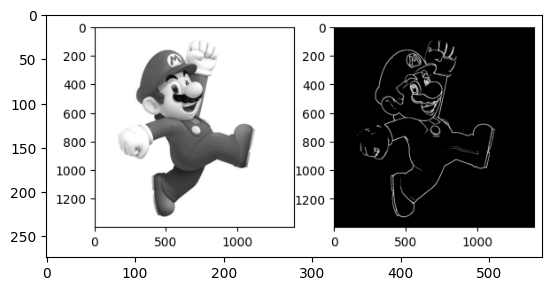

In [37]:
image = cv2.imread('/content/drive/My Drive/mario.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)              #since cv2.imread image in BGR format, we need to convert it into RGB format
gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)        #converting image to grayscale format
img_plot = plt.imshow(gray_image, cmap = 'gray')
plt.show()


# CONVOLUTION FUNCTION

In [38]:
def convolve(image,kernel):
  size_image = image.shape                       #get the dimensions of image
  ksize = kernel.shape                           #get the dimensions of kernel
  stride = 1                                     #how much a kernel moves after each step , currently not incorporated in our code
  cols = size_image[0]-ksize[0]+1
  rows = size_image[1]-ksize[1]+1
  cimage = np.zeros((cols,rows))                 #making an empty matrix initialized to zero of that size of the image matrix , it will be used to store values of the operation in the below loop
  sum = 0
  kernel_flipped = np.flipud(np.fliplr(kernel))  #flipping the kernel as it is need to perform convolution as otherwise it will be correlation
  for i in range(cols):                          #traversing the image matrix
    for j in range(rows):
      imp = image[i:i+ksize[0],j: j+ksize[1]]
      sum_mat = np.multiply(kernel_flipped,imp)  #taking element-wise multiplication of kernel and some section of image where the kernel has reached and getting a matrix
      sum_val = np.sum(sum_mat)                  #taking sum of all the elements of the matrix
      cimage[i,j] = sum_val
  return cimage

In [39]:
#testing if our function for convolution works
test = np.array([[1,1,1,1,1],[1,2,3,5,1],[1,2,4,5,1],[7,5,3,8,9],[5,1,1,1,1]])
print(test)
tkernel = np.array([[1,2],[3,-1]])
result = convolve(test,tkernel)

print(result)

[[1 1 1 1 1]
 [1 2 3 5 1]
 [1 2 4 5 1]
 [7 5 3 8 9]
 [5 1 1 1 1]]
[[ 6.  9. 13. 13.]
 [ 9. 15. 25.  9.]
 [24. 23. 25. 23.]
 [19.  7. 24. 22.]]


#Sharpening function


In [50]:
def sharpen(image):
  skernel = np.array([[-1/9,-1/9,-1/9],[-1/9,17/9,-1/9],[-1/9,-1/9,-1/9]])
  sharp_image = convolve(image,skernel)
  return sharp_image

#Blurring function

In [82]:
def blur(image):
  bkernel = np.array([[1/16,2/16,1/16],[2/16,4/16,2/16],[1/16,2/16,1/16]])
  # bkernel = np.array([[1/273,4/273,7/273,4/273,1/273],[4/273,16/273,26/273,16/273,4/273],[7/273,26/273,41/273,26/273,7/273],[4/273,16/273,26/273,16/273,4/273],[1/273,4/273,7/273,4/273,1/273]])
  blur_image = convolve(image,bkernel)
  return blur_image

# SOBEL
 Here we define the kernel for Sobel in X direction and Y direction.

In [52]:
s_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
s_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
print(s_x)
print(s_y)

[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


#SCHARR OPERATOR

In [53]:
sch_x = np.array([[-3,0,3],[-10,0,10],[-3,0,3]])
sch_y = np.array([[-3,-10,-3],[0,0,0],[3,10,3]])
print(sch_x)
print(sch_y)

[[ -3   0   3]
 [-10   0  10]
 [ -3   0   3]]
[[ -3 -10  -3]
 [  0   0   0]
 [  3  10   3]]


#EXPERIMENTATION

In [83]:
#doing all the blurring and sharpening here
blur_image = blur(gray_image)
sharp_image = sharpen(gray_image)
blur_sharp_image = blur(sharpen(gray_image))
sharp_blur_image = sharpen(blur(gray_image))

In [55]:
def only_edges_sobel(input_image):                                #function to perform sobel and then print the image
  grad_x = convolve(input_image,s_x)
  grad_y = convolve(input_image,s_y)
  abs_grad_x = cv2.convertScaleAbs(grad_x)
  abs_grad_y = cv2.convertScaleAbs(grad_y)
  grad = cv2.addWeighted(abs_grad_x,0.5,abs_grad_y,0.5,0)
  plt.imshow(grad,cmap = "gray")
def only_edges_scharr(input_image):
  grad_x = convolve(input_image,sch_x)
  grad_y = convolve(input_image,sch_y)
  abs_grad_x = cv2.convertScaleAbs(grad_x)
  abs_grad_y = cv2.convertScaleAbs(grad_y)
  grad = cv2.addWeighted(abs_grad_x,0.5,abs_grad_y,0.5,0)
  plt.imshow(grad,cmap = "gray")

SOBEL ON BLURRED IMAGE

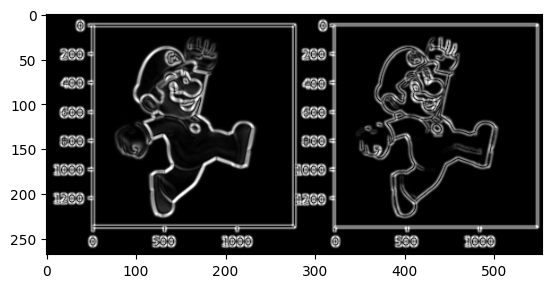

In [56]:
only_edges_sobel(blur_image)

SOBEL ON SHARP IMAGE

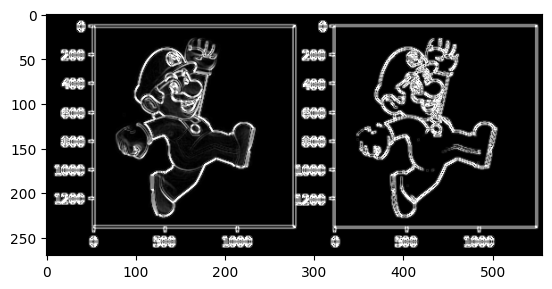

In [57]:
only_edges_sobel(sharp_image)

SCHARR ON BLURRED IMAGE

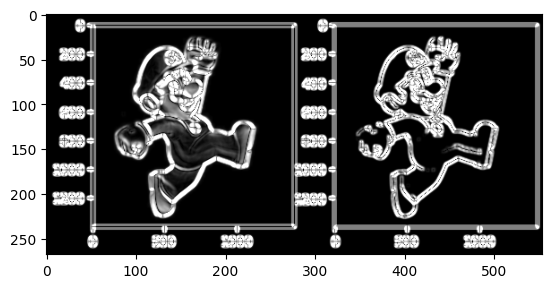

In [58]:
only_edges_scharr(blur_image)

SCHARR ON SHARP IMAGE

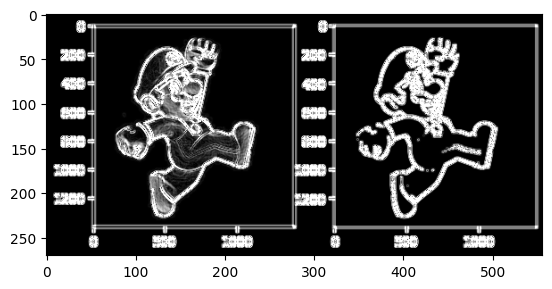

In [59]:
only_edges_scharr(sharp_image)

SCHARR ON BLURRED SHARP IMAGE

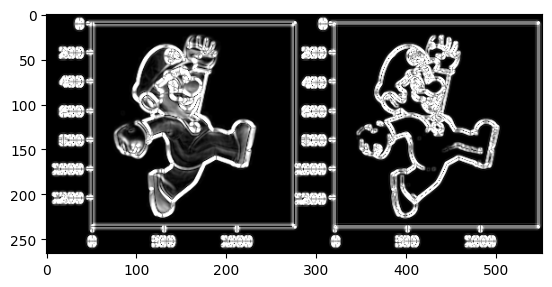

In [60]:
only_edges_scharr(blur_sharp_image)

SOBEL ON SHARPENED BLUR IMAGE

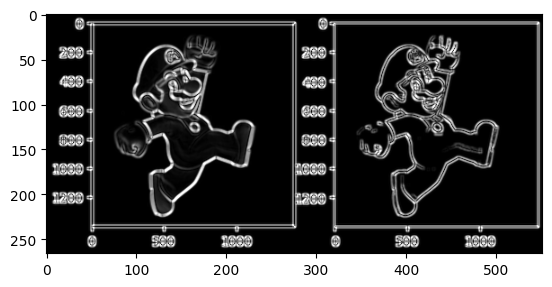

In [61]:
only_edges_sobel(sharp_blur_image)

SOBEL ON BLURRED SHARP IMAGE **bold text**

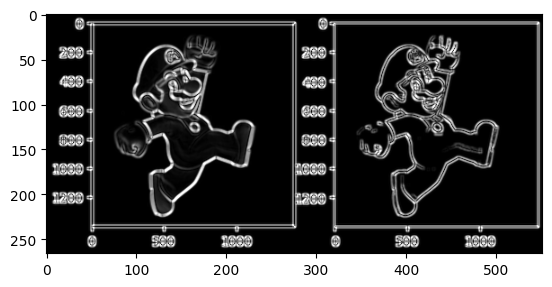

In [62]:
only_edges_sobel(blur_sharp_image)

# CANNY EDGE DETECTION

FIRST WE DEFINE ALL THE NECESSARY FUNCTION THAT FORM THE STEP OF CANNY FUNCTION

In [69]:
def non_max_suppression(img):
    blur_img = img                                                              # Noise reduction using Gaussian blurring (assuming you have a blur function)

    grad_x = convolve(blur_img, s_x)
    grad_y = convolve(blur_img, s_y)

    magnitude = np.sqrt(grad_x**2 + grad_y**2)                                   # Calculate gradient magnitude and angle
    angle = np.arctan2(grad_y, grad_x) * 180.0 / np.pi

    can = np.zeros_like(blur_img)
    for i in range(1, angle.shape[0] - 1):
      for j in range(1, angle.shape[1] - 1):
        if (angle[i, j] < 0):
            angle[i, j] += 180
        if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
            k1 = magnitude[i, j + 1]
            k2 = magnitude[i, j - 1]
        elif (22.5 <= angle[i, j] < 67.5):
            k1 = magnitude[i + 1, j - 1]
            k2 = magnitude[i - 1, j + 1]
        elif (67.5 <= angle[i, j] < 112.5):
            k1 = magnitude[i + 1, j]
            k2 = magnitude[i - 1, j]
        elif (112.5 <= angle[i, j] < 157.5):
            k1 = magnitude[i - 1, j - 1]
            k2 = magnitude[i + 1, j + 1]

        if (magnitude[i, j] >= k1) and (magnitude[i, j] >= k2):
            can[i, j] = magnitude[i, j]
        else:
            can[i, j] = 0
    print(angle.shape)
    return can

(268, 554)


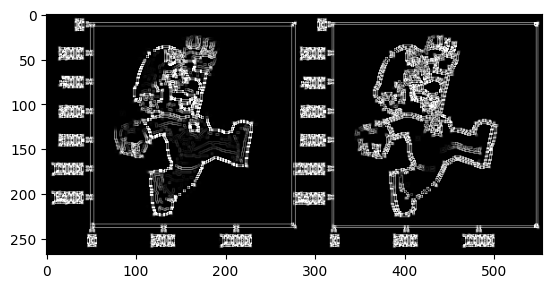

In [64]:
only_edges_sobel(non_max_suppression(gray_image))

In [86]:
def threshold(img, lowThresholdRatio=0.01, highThresholdRatio=0.07):
  highThreshold = img.max() * highThresholdRatio;
  lowThreshold = highThreshold * lowThresholdRatio;
  M, N = img.shape
  res = np.zeros((M,N))
  weak = 25
  strong = 255
  strong_i, strong_j = np.where(img >= highThreshold)
  zeros_i, zeros_j = np.where(img < lowThreshold)
  weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

  res[strong_i, strong_j] = strong
  res[weak_i, weak_j] = weak

  return res

In [87]:
def hysteresis(img):
    M, N = img.shape
    strong = 255
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == 25):
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
    return img


In [88]:
def canny(img):
  grad_x = convolve(img,s_x)
  grad_y = convolve(img,s_y)
  abs_grad_x = cv2.convertScaleAbs(grad_x)
  abs_grad_y = cv2.convertScaleAbs(grad_y)
  grad = np.sqrt((grad_x**2)+(grad_y**2))
  step1 = grad
  step2 = non_max_suppression(step1)
  step3 = threshold(step2)
  step4 = hysteresis(step3)
  plt.imshow(step4,cmap = 'gray')

(268, 554)


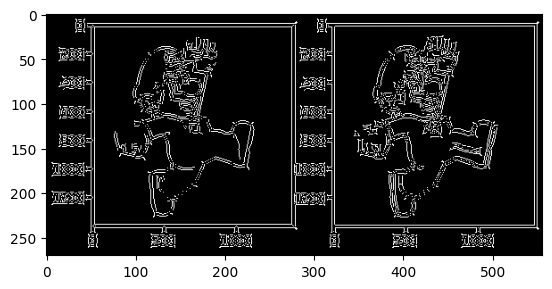

In [89]:
canny(blur_image)